Changed dt


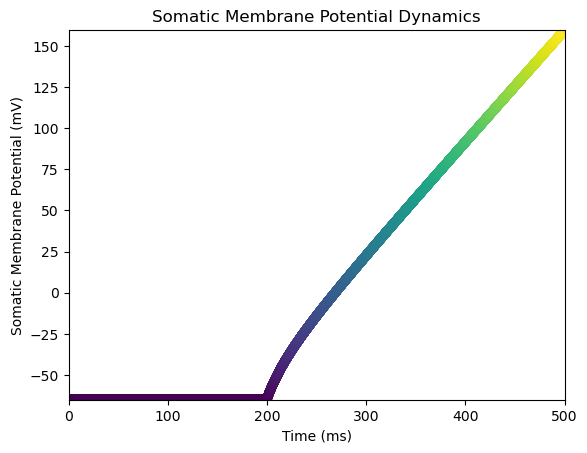

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from neuron import h, gui

def instantiate_swc(filename):
    """Load an SWC file and instantiate it"""
    h.load_file('import3d.hoc')
    cell = h.Import3d_SWC_read()
    cell.input(filename)
    i3d = h.Import3d_GUI(cell, 0)
    i3d.instantiate(None)
    return cell

def find_soma():
    """Find the soma section in the instantiated cell"""
    for sec in h.allsec():
        if "soma" in sec.name().lower():
            return sec
    return h.allsec()[0]

# Set up the NEURON model
swc_file = "reconstruction.swc"
cell = instantiate_swc(swc_file)
soma = find_soma()

soma_v = h.Vector()
soma_v.record(soma(0.5)._ref_v)

stim = h.IClamp(soma(0.5))
stim.amp = 0.09  # amplitude in nA
stim.delay = 200  # start time in ms
stim.dur = 300  # duration in ms

h.tstop = 500  # stop time in ms
h.dt = 0.1  # time step in ms

time = h.Vector()
time.record(h._ref_t)

# Run the simulation
h.finitialize(-80)  # initial membrane potential
h.run()

time_np = np.array(time)
soma_v_np = np.array(soma_v)

# Set up figure 
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
sc = ax.scatter([], [], c=[], cmap='viridis', vmin=np.min(soma_v_np), vmax=np.max(soma_v_np))

ax.set_xlim(np.min(time_np), np.max(time_np))
ax.set_ylim(np.min(soma_v_np), np.max(soma_v_np))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Somatic Membrane Potential (mV)')
ax.set_title('Somatic Membrane Potential Dynamics')

# Updates scatter plot with time
def update(frame):
    sc.set_offsets(np.c_[time_np[:frame], soma_v_np[:frame]])
    sc.set_array(soma_v_np[:frame])
    return sc,

# Animation
ani = animation.FuncAnimation(fig, update, frames=len(time_np), interval=20, blit=True)

ani.save('somatic_v_dynamics.mp4', writer='ffmpeg', fps=30)

plt.show()
